In [1]:
import sys
sys.path.append('..') 
import os

In [2]:
import psycopg2
import pandas as pd
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta

# Main

In [3]:
"""Main"""
# TODO
## Credentials must be read from the environment variables
## get_config can raise error when called in a .py file

'Main'

## Data Loading

In [4]:
"""DataLoad"""
from src.utils.config import get_config
from src.db_ops.db_ops import PosgreOps

# Load Config
config = get_config()
# Initialize database operator, this case posgre operator
pgops = PosgreOps(config=config)
### Define the required parameters to load the data ###
# -------------------------------------------------------- #
months = 84
table_name = "daas.epdk_petrol_province"
# -------------------------------------------------------- #
# Fetch data from database
epdk_petrol_province_data = pgops.get_monthly_data(table_name=table_name,
                                                today=date.today(), months=months)
# Close the connection after obtaining the data
pgops.shutdown()

In [5]:
# Investigate Results
print(epdk_petrol_province_data.shape)
print(epdk_petrol_province_data.province.nunique())
print(epdk_petrol_province_data.date.min())

(5904, 11)
82
2016-01-01


In [6]:
epdk_petrol_province_data.date.dtypes

dtype('O')

## Preprocessing

In [7]:
"""Preprocessing"""
from src.preprocessing.preprocess import PreprocessData

# Initialize preprocess object
prep = PreprocessData(data=epdk_petrol_province_data)
### Define parameters to preprocess ###
# -------------------------------------------------------- #
target_col_list = ["date","province","diesel_types"]
row_drop_dict = {"province": "Toplam"} 
# format_date_flag = True # True by default
col_rename_dict = {"diesel_types":"current_month_consumption"}
anomaly_col = "current_month_consumption" 
# -------------------------------------------------------- #
# Preprocess data with given parameters
preprocessed_df = prep.prep_data(target_col_list=target_col_list,
                                 row_drop_dict=row_drop_dict,
                                 col_rename_dict=col_rename_dict,
                                 anomaly_col=anomaly_col)


Missing Dates are:  [numpy.datetime64('2021-10-01T00:00:00.000000000')]


In [8]:
# Investigate results
print(preprocessed_df.shape)
print(preprocessed_df.province.nunique())
print(preprocessed_df.date.min())

(5913, 3)
81
2016-01-01 00:00:00


In [9]:
preprocessed_df.head()

,date,province,current_month_consumption
0,2016-01-01,ÇANKIRI,3082.148
1,2016-01-01,ÇANAKKALE,10286.528
2,2016-01-01,ÇORUM,7218.320
3,2016-01-01,DENİZLİ,31509.926
4,2016-01-01,DİYARBAKIR,9068.408


In [10]:
# Control whether the missing values at 2021-10-01 are filled 
preprocessed_df.query(f"date=='{date(2021,10,1)}'").sort_values(by="current_month_consumption").tail()

,date,province,current_month_consumption
5669,2021-10-01,KONYA,76596.319000
5607,2021-10-01,BURSA,86588.115500
5608,2021-10-01,İZMİR,110690.847500
5617,2021-10-01,ANKARA,186113.792667
5606,2021-10-01,İSTANBUL,323780.346000


In [11]:
preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5913 entries, 0 to 5912
Data columns (total 3 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       5913 non-null   datetime64[ns]
 1   province                   5913 non-null   object        
 2   current_month_consumption  5913 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 184.8+ KB


In [12]:
print(preprocessed_df.current_month_consumption.dtypes)

float64


In [13]:
# # Save preprocessed data
# preprocessed_df.to_csv("data/preprocessed_df.csv")
# # # Load preprocessed data
# parse_dates = ["date"]
# preprocessed_df = pd.read_csv('data/preprocessed_df.csv', index_col=[0], parse_dates=parse_dates)
# preprocessed_df.info()

## Plotting

Shape of dataframe is :  (73, 3)


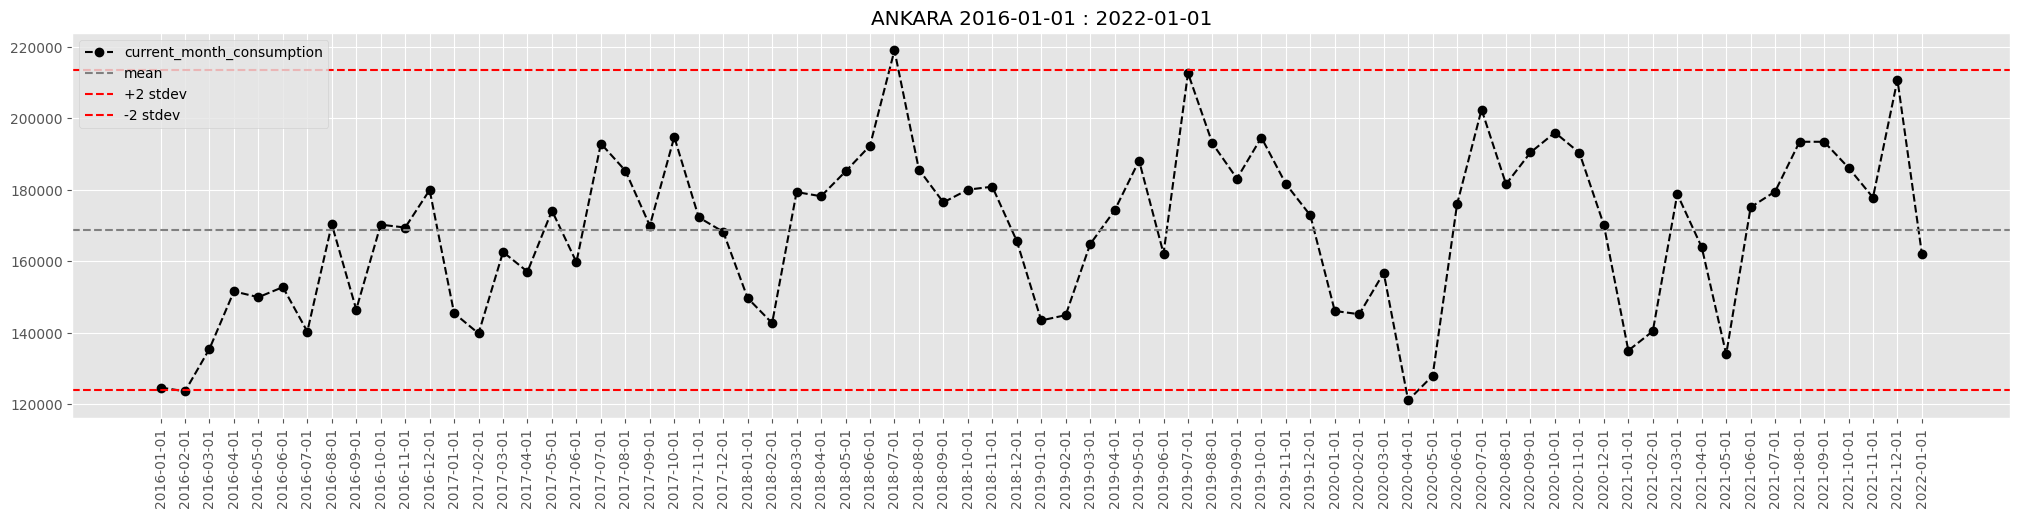

In [14]:
"""Plotting"""
from src.utils.plotting import plot_province

plot_province(df=preprocessed_df, col_x="date", col_y="current_month_consumption", province="ANKARA", stdev=2)

In [15]:
preprocessed_df.head()

,date,province,current_month_consumption
0,2016-01-01,ÇANKIRI,3082.148
1,2016-01-01,ÇANAKKALE,10286.528
2,2016-01-01,ÇORUM,7218.320
3,2016-01-01,DENİZLİ,31509.926
4,2016-01-01,DİYARBAKIR,9068.408


## Feature Engineering

In [16]:
"""FeatureEngineering"""
from src.feature_engineering.feat_eng import FeatureEngineering

# Initialize feature engineering object
feng = FeatureEngineering(data=preprocessed_df)
# Apply feature engineering to the preprocessed data
feature_engineered_df = feng.feature_engineering()

In [17]:
print(feature_engineered_df.shape)
feature_engineered_df.query("current_month_consumption%1==0")

(4698, 18)


,date,province,current_month_consumption,last_year_same_month_consumption,last_year_total_consumption,current_month_share,previous_1_month_share,previous_2_month_share,previous_3_month_share,previous_1_month_consumption,previous_2_month_consumption,previous_3_month_consumption,quarter,covid,school_holiday,2017_nufüs,2023_nüfus_prediction,Yıllık ortalama \nnüfus artış hızı
1152,2020-10-01,IĞDIR,7641.0,2838.76,33596.568,0.227434,0.107657,0.116035,0.118655,3466.843,3603.579,3591.387,4,1,10,194775,200459,4.794250
2296,2018-10-01,ARTVİN,5115.0,5492.85,56028.585,0.091293,0.084958,0.096013,0.088844,4779.558,5437.246,5089.899,4,0,10,166143,160947,-5.295918


In [19]:
# # Save feature_engineered_df 
# feature_engineered_df.to_csv("data/feature_engineered_df.csv")
# # # Load feature_engineered_df 
# parse_dates = ["date"]
# feature_engineered_df = pd.read_csv('data/feature_engineered_df.csv', index_col=[0], parse_dates=parse_dates)
# feature_engineered_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4698 entries, 15 to 5912
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   date                                4698 non-null   datetime64[ns]
 1   province                            4698 non-null   object        
 2   current_month_consumption           4698 non-null   float64       
 3   last_year_same_month_consumption    4698 non-null   float64       
 4   last_year_total_consumption         4698 non-null   float64       
 5   current_month_share                 4698 non-null   float64       
 6   previous_1_month_share              4698 non-null   float64       
 7   previous_2_month_share              4698 non-null   float64       
 8   previous_3_month_share              4698 non-null   float64       
 9   previous_1_month_consumption        4698 non-null   float64       
 10  previous_2_month_consum

## Model Selection

In [ ]:
model_df = feature_engineered_df.copy()
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4698 entries, 15 to 5912
Data columns (total 18 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   date                                4698 non-null   datetime64[ns]
 1   province                            4698 non-null   object        
 2   current_month_consumption           4698 non-null   float64       
 3   last_year_same_month_consumption    4698 non-null   float64       
 4   last_year_total_consumption         4698 non-null   float64       
 5   current_month_share                 4698 non-null   float64       
 6   previous_1_month_share              4698 non-null   float64       
 7   previous_2_month_share              4698 non-null   float64       
 8   previous_3_month_share              4698 non-null   float64       
 9   previous_1_month_consumption        4698 non-null   float64       
 10  previous_2_month_consum

In [ ]:
model_df.tail()

,date,province,current_month_consumption,last_year_same_month_consumption,last_year_total_consumption,current_month_share,previous_1_month_share,previous_2_month_share,previous_3_month_share,previous_1_month_consumption,previous_2_month_consumption,previous_3_month_consumption,quarter,covid,school_holiday,2017_nufüs,2023_nüfus_prediction,Yıllık ortalama \nnüfus artış hızı
5908,2021-09-01,KONYA,86783.316,83669.902,895873.718,0.096870,0.097819,0.102773,0.094687,86783.316,91256.724,83230.455,3,0,11,2180149,2324038,10.652179
5909,2021-10-01,KONYA,76596.319,84979.677,898987.132,0.085203,0.096870,0.097819,0.102773,86783.316,86783.316,91256.724,4,0,10,2180149,2324038,10.652179
5910,2021-11-01,KONYA,78440.184,83655.690,890603.774,0.088075,0.085203,0.096870,0.097819,76596.319,86783.316,86783.316,4,0,13,2180149,2324038,10.652179
5911,2021-12-01,KONYA,70236.884,62696.081,885388.268,0.079329,0.088075,0.085203,0.096870,78440.184,76596.319,86783.316,4,0,7,2180149,2324038,10.652179
5912,2022-01-01,KONYA,46077.490,55113.228,892929.071,0.051603,0.079329,0.088075,0.085203,70236.884,78440.184,76596.319,1,0,15,2180149,2324038,10.652179


In [ ]:
deneme = model_df.sort_values(by=["date"]).reset_index(drop=True).copy()

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=81)
cv = tscv
for train_index, test_index in tscv.split(deneme):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [   0    1    2 ... 4290 4291 4292] TEST: [4293 4294 4295 4296 4297 4298 4299 4300 4301 4302 4303 4304 4305 4306
 4307 4308 4309 4310 4311 4312 4313 4314 4315 4316 4317 4318 4319 4320
 4321 4322 4323 4324 4325 4326 4327 4328 4329 4330 4331 4332 4333 4334
 4335 4336 4337 4338 4339 4340 4341 4342 4343 4344 4345 4346 4347 4348
 4349 4350 4351 4352 4353 4354 4355 4356 4357 4358 4359 4360 4361 4362
 4363 4364 4365 4366 4367 4368 4369 4370 4371 4372 4373]
TRAIN: [   0    1    2 ... 4371 4372 4373] TEST: [4374 4375 4376 4377 4378 4379 4380 4381 4382 4383 4384 4385 4386 4387
 4388 4389 4390 4391 4392 4393 4394 4395 4396 4397 4398 4399 4400 4401
 4402 4403 4404 4405 4406 4407 4408 4409 4410 4411 4412 4413 4414 4415
 4416 4417 4418 4419 4420 4421 4422 4423 4424 4425 4426 4427 4428 4429
 4430 4431 4432 4433 4434 4435 4436 4437 4438 4439 4440 4441 4442 4443
 4444 4445 4446 4447 4448 4449 4450 4451 4452 4453 4454]
TRAIN: [   0    1    2 ... 4452 4453 4454] TEST: [4455 4456 4457 4458 4459 446

Shape of dataframe is :  (58, 18)


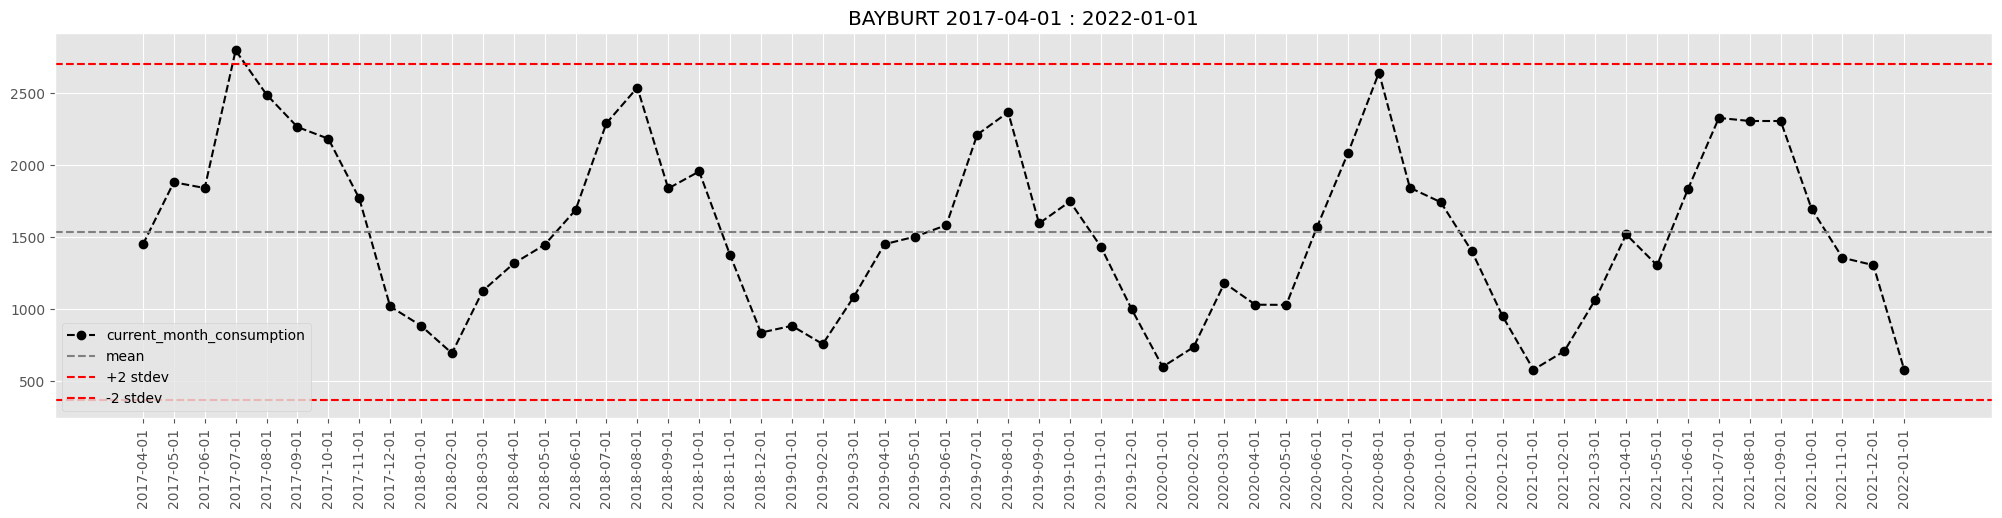

In [ ]:
plot_province(df=model_df, col_x="date", col_y="current_month_consumption", province="BAYBURT", stdev=2)

In [ ]:
# Initialization parameters
init_params = {
    "early_stopping_rounds": 20,
    "eval_metric": "rmsle", # default ,mae(kötü) ,mape(kötü), rmse, rmsle(1 tane 54 gerisi 20nin altında), 
}

# Grid Search Parameters
grid_search_params = {    
    'colsample_bytree': [0.9, 1.0],
    'gamma': [0, 0.2],
    # 'max_depth': [8, 9, 10],
    # 'min_child_weight': [2, 3],
    'n_estimators': [250, 500],
    # 'subsample': [0.9, 1],
}
# {'colsample_bytree': 1.0,
#  'gamma': 0,
#  'max_depth': 8,
#  'min_child_weight': 3,
#  'n_estimators': 500,
#  'subsample': 1}

In [ ]:
from src.model_selection.data_preperation import DataPreperation
from src.model_selection.modelling import xgb_simulator
last_n_months = 1
for lag in range(last_n_months):
    print("lag is: ",lag)
    # Initialize Data Preperation module
    dp = DataPreperation(data=model_df)
    # Train-Test split
    # # former
    X_train, y_train, X_test, y_test = dp.tts_last_month(index_column1="date" ,index_column2="province",lag=lag)
    # latter
    # X_train, y_train, X_test, y_test, X_val, y_val = dp.ttvs_last_month(index_column1="date" ,index_column2="province",lag=lag, split_size = 0.05)
    # print("Maximum date at val is: ", X_test.index.max(), " Shape is: ", X_val.shape)
    # print("Minimum date at val is: ", X_test.index.min(), " Shape is: ", X_val.shape)  
    print("Maximum date at train is: ", X_train.index.max()," Shape is: ", X_train.shape)
    print("Minimum date at train is: ", X_train.index.min()," Shape is: ", X_train.shape)
    print("Maximum date at test is: ", X_test.index.max(), " Shape is: ", X_test.shape)
    print("Minimum date at test is: ", X_test.index.min(), " Shape is: ", X_test.shape)
  
    # fitting parameters
    # fit_params = {
    #     "eval_set": [(X_val,y_val)]
    # }
    fit_params = {
        "eval_set": [(X_test,y_test)]
    }    
    # Initialize Simulator
    xgb = xgb_simulator(init_params=init_params, fit_params=fit_params, grid_search_params=grid_search_params)
    # Train the model
    xgb(X_train=X_train, y_train=y_train)
    # Set the best_model and best_parameter
    best_model = xgb.best_model
    best_params = xgb.best_params
    # Log Results here
    

lag is:  0
Maximum date at train is:  (Timestamp('2021-12-01 00:00:00'), 'ŞIRNAK')  Shape is:  (4617, 15)
Minimum date at train is:  (Timestamp('2017-04-01 00:00:00'), 'ADANA')  Shape is:  (4617, 15)
Maximum date at test is:  (Timestamp('2022-01-01 00:00:00'), 'ŞIRNAK')  Shape is:  (81, 15)
Minimum date at test is:  (Timestamp('2022-01-01 00:00:00'), 'ADANA')  Shape is:  (81, 15)


TypeError: train_() missing 1 required positional argument: 'cv'

In [ ]:
best_params

In [ ]:
# Predict test set
predictons = best_model.predict(X_test)

In [ ]:
import numpy as np
# Prepare Results df
results_df = X_test.copy()
results_df["actual_value"] = y_test["current_month_consumption"]
results_df.reset_index(level="province",inplace=True)
results_df["overall_model_prediction"] = predictons
results_df["overall_model_mse"] = np.square(np.subtract(results_df["actual_value"], results_df["overall_model_prediction"]))/2
results_df["overall_model_percent_diff"] = abs(results_df["actual_value"]-results_df["overall_model_prediction"])/results_df["actual_value"]*100
results_df = results_df[["province", "actual_value","overall_model_prediction","overall_model_mse","overall_model_percent_diff"]]
results_df["single_model_prediction"] = 0
results_df["single_model_percent_diff"] = 0
results_df["single_model_mse"] = 0

In [ ]:
results_df.sort_values(by=["overall_model_percent_diff"], ascending=False).head(20)

In [ ]:
from src.utils.plotting import plot_metrics
plot_metrics(results_df, col_x="province", col_y1="overall_model_percent_diff", col_y2="single_model_percent_diff")

In [ ]:
class daglar():
    def __init__(self,**kwargs):
        self.dada(**kwargs)
    def dada(self,**kwargs):
        if kwargs:
            print(kwargs)
my_dict = {"daglar":"iyi","deneme":"kötü", "foo":"boo"}
my_list = [1,2,3,4]
deneme = daglar(my_dict=my_dict, myList=my_list)